In [1]:
## Purpose:
## To perform stratified K-Fold-Cross-Validation

In [543]:
## Import all required libraries
import numpy as np
import os 
import pandas as pd
import tensorflow as tf
import ast
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
from sklearn.model_selection import StratifiedKFold
from numpy import asarray
from numpy import savetxt, loadtxt
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import scipy
import scipy.stats as st
import scikitplot as skplt

In [2]:
## Set current working directory
os.chdir("/media/data/Projects/ICCAVSMETS")

In [3]:
## Set project directory SSD
SSDDir = '/home/thomas/Projects/ICCAvsMETS'
FiguresDir = SSDDir+'/Figures/CrossValidation/'
model_dir = SSDDir+'/saved_models/CrossValidation/'

In [4]:
## Define folder of Source Images to be processed
## Folders should have the following hierachy: */Category/Material/**.svs
NormalizedTiles = 'Tiles/Normalized'
Sets = 'Tiles/Sets'
TrainingSetDir = 'Tiles/Sets/Train'
TestSetDir = 'Tiles/Sets/Test'

In [5]:
## Define lists
PatientNo = []
Category = []
Tilename = []

In [6]:
## Get FrozenModel name for each of the k iterations
def get_frozen_model_name(k):
    return 'frozen_model_'+str(k)+'.h5'

In [7]:
## Get tuned Model name for each of the k iterations
def get_tuned_model_name(k):
    return 'tuned_model_'+str(k)+'.h5'

In [8]:
## Ungroup the tables for each fold
def ungroup_data_table(DataTable):

    Tilenames_new = []
    Tilenames_flatten = []
    Category_new = []
    PatientNo_new = []
    n = 0

    for i in DataTable['Tilenames']:
        Tilenames_new.append(i)
        for a in range(i.count(', ')+1):
            PatientNo_new.append(DataTable.loc[n, 'PatientNo'])
            Category_new.append(DataTable.loc[n, 'Category'])
        n = n + 1

    Tilenames_flatten = [inner for item in Tilenames_new for inner in ast.literal_eval(item)] 
    Ungrouped_DataTable = pd.DataFrame({'PatientNo': PatientNo_new, 'Category': Category_new, 'Tilenames': Tilenames_flatten})
    return Ungrouped_DataTable

In [9]:
## Read TrainingSet Table
TrainTable = pd.read_csv(SSDDir+'/Tables/TrainTable.csv')

In [10]:
## Fixed Parameters
num_classes = TrainTable['Category'].nunique()
if num_classes == 2:
    num_classes = num_classes-1
num_patients = len(TrainTable.index)

In [11]:
## Variable Parameters
num_epochs = 100
img_height = 300
img_width = 300
IMAGE_SIZE = [img_height, img_width]

In [12]:
## Define Target Variable and create Instance
y = TrainTable['Category']
skf = StratifiedKFold(n_splits = 4, random_state = 7, shuffle = True)

In [15]:
## Create Instances of ImageDataGenerator
idg_train = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   vertical_flip=True,
                                   horizontal_flip=True)

idg_valid = ImageDataGenerator(preprocessing_function=preprocess_input)

In [16]:
## Download most current weights
##!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b3.tar.gz -P /home/thomas/Projects/ICCAvsMETS/weights
##!tar -xf /home/thomas/Projects/ICCAvsMETS/weights/noisy_student_efficientnet-b3.tar.gz -C /home/thomas/Projects/ICCAvsMETS/weights
##!python /home/thomas/Projects/VENV/efficientnet_weight_update_util.py --model b3 --notop --ckpt /home/thomas/Projects/ICCAvsMETS/weights/noisy-student-efficientnet-b3/model.ckpt --o /home/thomas/Projects/ICCAvsMETS/weights/noisy-student-efficientnet-b3/efficientnetb3_notop.h5

In [17]:
## Source for updated weights
##weights_B5 = '/home/thomas/Projects/ICCAvsMETS/weights/noisy-student-efficientnet-b5/efficientnetb5_notop.h5'
weights_B3 = '/home/thomas/Projects/ICCAvsMETS/weights/noisy-student-efficientnet-b3/efficientnetb3_notop.h5'

In [18]:
## Performing cross-validation via K-Fold-Splitting, Transfer learning and Fine Tuning
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
best_epochs_transfer = []
best_epochs_tuning = []
top_dropout_rate = 0.2
fold_var = 1

probabilities_tiles = []
probabilities_patient = []
PredTableTileLevel = []
PredTableTileLevel = []

for train_index, val_index in skf.split(np.zeros(num_patients),y):
        training_data_grouped = TrainTable.iloc[train_index].reset_index(drop=True)
        validation_data_grouped = TrainTable.iloc[val_index].reset_index(drop=True)
        
        training_data = ungroup_data_table(training_data_grouped)
        validation_data = ungroup_data_table(validation_data_grouped)
        
        train_data_generator = idg_train.flow_from_dataframe(training_data, directory = TrainingSetDir,
                                                       x_col = "Tilenames", y_col = "Category", 
                                                       batch_size = 32,
                                                       target_size = (img_height, img_width),
                                                       class_mode = "binary", shuffle = True)
        valid_data_generator  = idg_valid.flow_from_dataframe(validation_data, directory = TrainingSetDir,
                                                        x_col = "Tilenames", y_col = "Category",
                                                        target_size = (img_height, img_width),
                                                        class_mode = "binary", shuffle = False)
        
        # CREATE NEW MODEL
        inputs = tf.keras.Input(shape=(img_height, img_width, 3))
        base = EfficientNetB3 (include_top=False, weights=weights_B3, input_tensor=inputs, input_shape=(img_height, img_width, 3))

        # Freeze the pretrained weights
        base.trainable = False

        # Rebuild top (IMPORTANT: run in inference mode by setting training=false for finetuning)
        top_activation_layer = base.get_layer('top_activation')
        x = layers.GlobalAveragePooling2D(name="avg_pool")(top_activation_layer.output)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
        x = layers.Dense(num_classes, activation="sigmoid", name="pred")(x)
        
        MyModel = tf.keras.Model(inputs=inputs, outputs=x)

        # COMPILE NEW MODEL
        opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
        MyModel.compile(loss='binary_crossentropy',
                        optimizer=opt,
                        metrics=['accuracy'])
     
        # CREATE CALLBACKS
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        checkpoint = tf.keras.callbacks.ModelCheckpoint(model_dir+get_frozen_model_name(fold_var), 
                                                        monitor='val_loss', verbose=1, 
                                                        save_best_only=True, mode='min')
        callbacks_list = [es, checkpoint]
                
        # Set step size
        STEP_SIZE_TRAIN=train_data_generator.n//train_data_generator.batch_size
        STEP_SIZE_VALID=valid_data_generator.n//valid_data_generator.batch_size
        
        # FIT THE MODEL
        history = MyModel.fit(train_data_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              epochs=num_epochs,
                              validation_data=valid_data_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callbacks_list)
        hist = MyModel.history.history['val_loss']
        n_epochs_best = np.argmin(hist) + 1
        best_epochs_transfer.append(n_epochs_best)
                                    
        ## LOAD BEST MODEL WEIGHTS FOR FINETUNING
        MyModel.load_weights(model_dir+get_frozen_model_name(fold_var))
        
        # Unfreeze the base model
        base.trainable = True
        for layer in MyModel.layers:
            if isinstance(layer, layers.BatchNormalization):
                layer.trainable = False
        
        # Recompile
        opt2 = tf.keras.optimizers.Adam(learning_rate=1e-4)
        MyModel.compile(loss='binary_crossentropy',
                        optimizer=opt2,
                        metrics=['accuracy'])
        
        # CREATE NEW CALLBACKS
        es2 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        checkpoint2 = tf.keras.callbacks.ModelCheckpoint(model_dir+get_tuned_model_name(fold_var), 
                                                         monitor='val_loss', verbose=1, 
                                                         save_best_only=True, mode='min')
        callbacks_list2 = [es2, checkpoint2]
        
        # Fine tuning
        history = MyModel.fit(train_data_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              epochs=num_epochs,
                              validation_data=valid_data_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callbacks_list2)
        hist = MyModel.history.history['val_loss']
        n_epochs_best = np.argmin(hist) + 1
        best_epochs_tuning.append(n_epochs_best)
        
        # LOAD BEST MODEL TO EVALUATE FINAL PERFORMANCE
        MyModel.load_weights(model_dir+get_tuned_model_name(fold_var))
        
        results = MyModel.evaluate(valid_data_generator)
        results = dict(zip(MyModel.metrics_names,results))
        
        VALIDATION_ACCURACY.append(results['accuracy'])
        VALIDATION_LOSS.append(results['loss'])
        
        ## Save Dataframe for Tile Prediction
        predictions = MyModel.predict(valid_data_generator)
        PredTableTileLevel = validation_data.copy()
        PredTableTileLevel['Predictions'] = predictions    
        probabilities_tiles.append(PredTableTileLevel)
        PredTableTileLevel.to_csv('/home/thomas/Projects/ICCAvsMETS/Tables/PredTableTileLevel_cv_'+str(fold_var)+'.csv', index=False)
        
        ## Save Dataframe for Patient Prediction
        PredTablePatientLevel = PredTableTileLevel.groupby(['PatientNo', 'Category'])['Predictions'].agg(list).reset_index()
        PredTablePatientLevel['Predictions_mean'] = PredTablePatientLevel['Predictions'].apply(np.mean)
        probabilities_patient.append(PredTablePatientLevel)
        PredTablePatientLevel.to_csv('/home/thomas/Projects/ICCAvsMETS/Tables/PredTablePatientLevel_cv_'+str(fold_var)+'.csv', index=False)
       
        PredTablePatientLevel = []
        PredTableTileLevel = []
    
        tf.keras.backend.clear_session()
        
        fold_var += 1

Found 537345 validated image filenames belonging to 2 classes.
Found 177244 validated image filenames belonging to 2 classes.
Epoch 1/100
16792/16792 [==============================] - 10432s 621ms/step - loss: 0.4004 - accuracy: 0.8254 - val_loss: 0.3562 - val_accuracy: 0.8459

Epoch 00001: val_loss improved from inf to 0.35618, saving model to /home/thomas/Projects/ICCAvsMETS/saved_models/CrossValidation/frozen_model_1.h5


/home/thomas/.virtualenvs/TF2.5/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
16792/16792 [==============================] - 7190s 428ms/step - loss: 0.3915 - accuracy: 0.8260 - val_loss: 0.3407 - val_accuracy: 0.8540

Epoch 00002: val_loss improved from 0.35618 to 0.34071, saving model to /home/thomas/Projects/ICCAvsMETS/saved_models/CrossValidation/frozen_model_1.h5
Epoch 3/100
16792/16792 [==============================] - 3921s 234ms/step - loss: 0.3925 - accuracy: 0.8258 - val_loss: 0.3923 - val_accuracy: 0.8297

Epoch 00003: val_loss did not improve from 0.34071
Epoch 4/100
16792/16792 [==============================] - 4309s 257ms/step - loss: 0.3919 - accuracy: 0.8261 - val_loss: 0.3747 - val_accuracy: 0.8367

Epoch 00004: val_loss did not improve from 0.34071
Epoch 5/100
16792/16792 [==============================] - 5367s 320ms/step - loss: 0.3921 - accuracy: 0.8263 - val_loss: 0.3625 - val_accuracy: 0.8441

Epoch 00005: val_loss did not improve from 0.34071
Epoch 6/100
16792/16792 [==============================] - 4656s 277ms/step - loss:

/home/thomas/.virtualenvs/TF2.5/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
17929/17929 [==============================] - 4908s 274ms/step - loss: 0.3906 - accuracy: 0.8283 - val_loss: 0.4056 - val_accuracy: 0.8175

Epoch 00002: val_loss did not improve from 0.38009
Epoch 3/100
17929/17929 [==============================] - 5950s 332ms/step - loss: 0.3894 - accuracy: 0.8286 - val_loss: 0.4053 - val_accuracy: 0.8149

Epoch 00003: val_loss did not improve from 0.38009
Epoch 4/100
17929/17929 [==============================] - 5350s 298ms/step - loss: 0.3894 - accuracy: 0.8283 - val_loss: 0.4190 - val_accuracy: 0.8082

Epoch 00004: val_loss did not improve from 0.38009
Epoch 5/100
17929/17929 [==============================] - 4732s 264ms/step - loss: 0.3901 - accuracy: 0.8291 - val_loss: 0.4125 - val_accuracy: 0.8146

Epoch 00005: val_loss did not improve from 0.38009
Epoch 6/100
17929/17929 [==============================] - 5663s 316ms/step - loss: 0.3888 - accuracy: 0.8288 - val_loss: 0.4045 - val_accuracy: 0.8212

Epoch 00006: val_loss did not i

/home/thomas/.virtualenvs/TF2.5/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
15641/15641 [==============================] - 4976s 318ms/step - loss: 0.4151 - accuracy: 0.8143 - val_loss: 0.3848 - val_accuracy: 0.8284

Epoch 00002: val_loss did not improve from 0.32157
Epoch 3/100
15641/15641 [==============================] - 6250s 400ms/step - loss: 0.4153 - accuracy: 0.8147 - val_loss: 0.3049 - val_accuracy: 0.8747

Epoch 00003: val_loss improved from 0.32157 to 0.30489, saving model to /home/thomas/Projects/ICCAvsMETS/saved_models/CrossValidation/frozen_model_3.h5
Epoch 4/100
15641/15641 [==============================] - 5620s 359ms/step - loss: 0.4141 - accuracy: 0.8147 - val_loss: 0.3927 - val_accuracy: 0.8174

Epoch 00004: val_loss did not improve from 0.30489
Epoch 5/100
15641/15641 [==============================] - 5066s 324ms/step - loss: 0.4154 - accuracy: 0.8144 - val_loss: 0.3537 - val_accuracy: 0.8431

Epoch 00005: val_loss did not improve from 0.30489
Epoch 6/100
15641/15641 [==============================] - 6043s 386ms/step - loss:

/home/thomas/.virtualenvs/TF2.5/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
16629/16629 [==============================] - 5123s 308ms/step - loss: 0.3872 - accuracy: 0.8294 - val_loss: 0.3698 - val_accuracy: 0.8366

Epoch 00002: val_loss improved from 0.41278 to 0.36980, saving model to /home/thomas/Projects/ICCAvsMETS/saved_models/CrossValidation/frozen_model_4.h5
Epoch 3/100
16629/16629 [==============================] - 6340s 381ms/step - loss: 0.3878 - accuracy: 0.8295 - val_loss: 0.3705 - val_accuracy: 0.8359

Epoch 00003: val_loss did not improve from 0.36980
Epoch 4/100
16629/16629 [==============================] - 6261s 377ms/step - loss: 0.3879 - accuracy: 0.8287 - val_loss: 0.3695 - val_accuracy: 0.8335

Epoch 00004: val_loss improved from 0.36980 to 0.36952, saving model to /home/thomas/Projects/ICCAvsMETS/saved_models/CrossValidation/frozen_model_4.h5
Epoch 5/100
16629/16629 [==============================] - 5237s 315ms/step - loss: 0.3882 - accuracy: 0.8287 - val_loss: 0.3720 - val_accuracy: 0.8344

Epoch 00005: val_loss did not imp

In [13]:
## Load all dataframes
probabilities_tiles = []
probabilities_patient = []

PredTablePatientLevel1 = pd.read_csv('/home/thomas/Projects/ICCAvsMETS/Tables/PredTablePatientLevel_cv_1.csv')
PredTablePatientLevel2 = pd.read_csv('/home/thomas/Projects/ICCAvsMETS/Tables/PredTablePatientLevel_cv_2.csv')
PredTablePatientLevel3 = pd.read_csv('/home/thomas/Projects/ICCAvsMETS/Tables/PredTablePatientLevel_cv_3.csv')
PredTablePatientLevel4 = pd.read_csv('/home/thomas/Projects/ICCAvsMETS/Tables/PredTablePatientLevel_cv_4.csv')
probabilities_patient.append(PredTablePatientLevel1)
probabilities_patient.append(PredTablePatientLevel2)
probabilities_patient.append(PredTablePatientLevel3)
probabilities_patient.append(PredTablePatientLevel4)

PredTableTileLevel1 = pd.read_csv('/home/thomas/Projects/ICCAvsMETS/Tables/PredTableTileLevel_cv_1.csv')
PredTableTileLevel2 = pd.read_csv('/home/thomas/Projects/ICCAvsMETS/Tables/PredTableTileLevel_cv_2.csv')
PredTableTileLevel3 = pd.read_csv('/home/thomas/Projects/ICCAvsMETS/Tables/PredTableTileLevel_cv_3.csv')
PredTableTileLevel4 = pd.read_csv('/home/thomas/Projects/ICCAvsMETS/Tables/PredTableTileLevel_cv_4.csv')
probabilities_tiles.append(PredTableTileLevel1)
probabilities_tiles.append(PredTableTileLevel2)
probabilities_tiles.append(PredTableTileLevel3)
probabilities_tiles.append(PredTableTileLevel4)

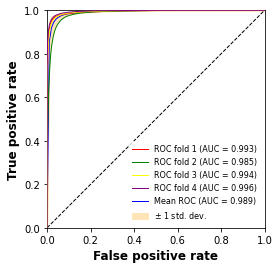

In [14]:
## Plot ROC-Curves Tiles Level (Validation-Set)
tprs = []
aucs = []
i = 1
mean_fpr = np.linspace(0, 1, 100)
colors = ['red', 'green', 'yellow', 'purple']

for dataframe in probabilities_tiles:
    fpr, tpr, thresholds = roc_curve(dataframe['Category'], dataframe['Predictions'], pos_label='KolonMet')
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1.0, label='ROC fold %d (AUC = %0.3f)' % (i, roc_auc), color = colors[i-1], zorder=3)
    i = i + 1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.3f)' % (mean_auc),
        lw=1, zorder=2)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(aucs, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(aucs, p))
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='moccasin',
                 label='$\pm$ 1 std. dev.', zorder=1)
plt.plot([0,1],[0,1],'k--',linewidth = 1.0, color = 'black')
plt.xlabel('False positive rate', fontsize=12, fontweight='bold')
plt.ylabel('True positive rate', fontsize=12, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xlim(0,1)
plt.ylim(0,1)
plt.gca().set_aspect('equal', adjustable='box')
leg = plt.legend(loc='lower right', fontsize=8)
leg.get_frame().set_linewidth(0.0)
plt.gca().spines['left'].set_zorder(2)
plt.gca().spines['top'].set_zorder(2)
plt.savefig(FiguresDir+'ROC_CV_TileLV.png', dpi=1200, bbox_inches='tight')
plt.show()

In [15]:
## Determine optimal threshold via Youden statistics and save
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_TileLevel = thresholds[optimal_idx]

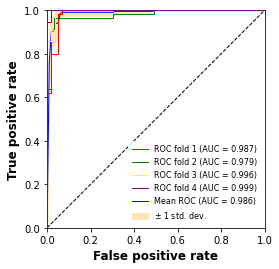

In [16]:
## Plot ROC-Curves Patient Level
tprs = []
aucs = []
i = 1
mean_fpr = np.linspace(0, 1, 100)
colors = ['red', 'green', 'yellow', 'purple']

for dataframe in probabilities_patient:
    fpr, tpr, thresholds = roc_curve(dataframe['Category'], dataframe['Predictions_mean'], pos_label='KolonMet')
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (AUC = %0.3f)' % (i, roc_auc), color = colors[i-1], zorder=3)
    i = i + 1

plt.plot([0,1],[0,1],linestyle = '--',lw = 1,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.3f)' % (mean_auc),
        lw=1, zorder=2)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(aucs, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(aucs, p))
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='moccasin',
                 label='$\pm$ 1 std. dev.', zorder=1)

plt.xlabel('False positive rate', fontsize=12, fontweight='bold')
plt.ylabel('True positive rate', fontsize=12, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xlim(0,1)
plt.ylim(0,1)
plt.gca().set_aspect('equal', adjustable='box')
leg = plt.legend(loc='lower right', fontsize=8)
leg.get_frame().set_linewidth(0.0)
plt.gca().spines['left'].set_zorder(2)
plt.gca().spines['top'].set_zorder(2)
plt.savefig(FiguresDir+'ROC_CV_PatientLV.png', dpi=1200, bbox_inches='tight')
plt.show()

In [17]:
## Determine optimal threshold on patient level
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_PatientLevel = thresholds[optimal_idx]

In [18]:
## Save Thresholds
Thresholds_CV = np.asarray([optimal_threshold_TileLevel, optimal_threshold_PatientLevel])
savetxt('/home/thomas/Projects/ICCAvsMETS/Tables/Thresholds_CV.csv', Thresholds_CV, delimiter=',')

In [19]:
## Define positive and negative category
PosCategory = 'KolonMet'
NegCategory = 'ICCA'

In [20]:
## Find predicted class and append in list on tile level
predicted_class = []
for dataframe in probabilities_tiles:
    for i in dataframe['Predictions']:
        if i > 0.5:
            predicted_class.append(PosCategory)
        else:
            predicted_class.append(NegCategory)
    dataframe['PredictedClass'] = predicted_class
    predicted_class = []

In [21]:
## Find predicted class and append in list on patient level
predicted_class = []
for dataframe in probabilities_patient:
    for i in dataframe['Predictions_mean']:
        if i > 0.5:
            predicted_class.append(PosCategory)
        else:
            predicted_class.append(NegCategory)
    dataframe['PredictedClass'] = predicted_class
    predicted_class = []

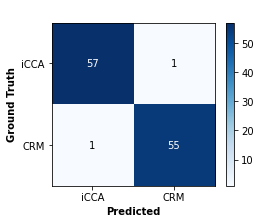

In [22]:
# Generate confusion matrix on Patient Level (absolute)
skplt.metrics.plot_confusion_matrix(PredTablePatientLevel4['Category'], PredTablePatientLevel4['PredictedClass'], title = ' ', figsize = (4,3),normalize=False)
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Ground Truth', fontweight='bold')
locs, labels = plt.xticks() 
plt.xticks(locs,['iCCA', 'CRM'])
locs, labels = plt.yticks() 
plt.yticks(locs,['iCCA', 'CRM'])
plt.savefig(FiguresDir+'CoMa_Test_CV_PatientLV_abs.png', dpi=1200, bbox_inches='tight')
plt.show()

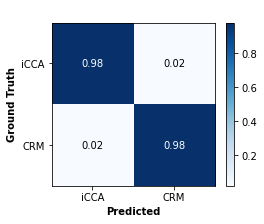

In [23]:
# Generate confusion matrix on Patient Level (relative)
skplt.metrics.plot_confusion_matrix(PredTablePatientLevel4['Category'], PredTablePatientLevel4['PredictedClass'], title = ' ', figsize = (4,3),normalize=True)
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Ground Truth', fontweight='bold')
locs, labels = plt.xticks() 
plt.xticks(locs,['iCCA', 'CRM'])
locs, labels = plt.yticks() 
plt.yticks(locs,['iCCA', 'CRM'])
plt.savefig(FiguresDir+'CoMa_Test_CV_PatientLV_rel.png', dpi=1200, bbox_inches='tight')
plt.show()

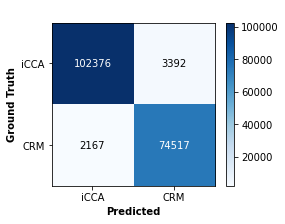

In [24]:
# Generate confusion matrix on Tile Level
skplt.metrics.plot_confusion_matrix(PredTableTileLevel4['Category'], PredTableTileLevel4['PredictedClass'], title = ' ', figsize = (4,3), normalize=False)
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Ground Truth', fontweight='bold')
locs, labels = plt.xticks() 
plt.xticks(locs,['iCCA', 'CRM'])
locs, labels = plt.yticks() 
plt.yticks(locs,['iCCA', 'CRM'])
plt.savefig(FiguresDir+'CoMa_Test_CV_TileLV_abs.png', dpi=1200, bbox_inches='tight')
plt.show()

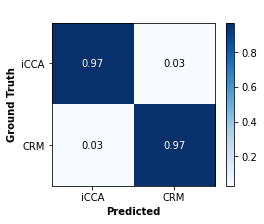

In [25]:
# Generate confusion matrix on Tile Level
skplt.metrics.plot_confusion_matrix(PredTableTileLevel4['Category'], PredTableTileLevel4['PredictedClass'], title = ' ', figsize = (4,3), normalize=True)
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Ground Truth', fontweight='bold')
locs, labels = plt.xticks() 
plt.xticks(locs,['iCCA', 'CRM'])
locs, labels = plt.yticks() 
plt.yticks(locs,['iCCA', 'CRM'])
plt.savefig(FiguresDir+'CoMa_Test_CV_TileLV_rel.png', dpi=1200, bbox_inches='tight')
plt.show()

In [26]:
##Compute metrics on tile level. Arbritarly, colorectal metastasis is defined as disease.  
Metrics_TileLevel_CV = pd.DataFrame(columns=['Name', 'Accuracy','Sensitivity','Specificity','PPV','NPV'])
names = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Mean', 'SD']
Metrics_TileLevel_CV['Name'] = names
accuracy_list = []
accuracy_list_stats = []
sensitivity_list = []
sensitivity_list_stats = []
specificity_list = []
specificity_list_stats = []
ppv_list = []
ppv_list_stats = []
npv_list = []
npv_list_stats = []

for dataframe in probabilities_tiles:
    KolonMet_TileNo = dataframe.loc[dataframe['Category'] == 'KolonMet'].shape[0]
    KolonMet_correct = dataframe.loc[(dataframe['Category'] == 'KolonMet') & (dataframe['PredictedClass'] == 'KolonMet')].shape[0]
    KolonMet_allPositive = dataframe.loc[dataframe['PredictedClass'] == 'KolonMet'].shape[0]
    KolonMet_allNegative = dataframe.loc[dataframe['PredictedClass'] == 'ICCA'].shape[0]
    KolonMet_correctneg = dataframe.loc[(dataframe['Category'] == 'ICCA') & (dataframe['PredictedClass'] == 'ICCA')].shape[0]

    ICCA_TileNo = dataframe.loc[dataframe['Category'] == 'ICCA'].shape[0]
    ICCA_correct = dataframe.loc[(dataframe['Category'] == 'ICCA') & (dataframe['PredictedClass'] == 'ICCA')].shape[0]

    accuracy_list.append(np.round(((KolonMet_correct+ICCA_correct)/(KolonMet_TileNo+ICCA_TileNo))*100,2))
    sensitivity_list.append(np.round((KolonMet_correct/KolonMet_TileNo)*100,2))
    specificity_list.append(np.round((ICCA_correct/ICCA_TileNo)*100,2))
    ppv_list.append(np.round((KolonMet_correct/KolonMet_allPositive)*100,2))
    npv_list.append(np.round((KolonMet_correctneg/KolonMet_allNegative)*100,2))

accuracy_list_stats.append(np.round((np.mean(accuracy_list)),3))
accuracy_list_stats.append(np.round((np.std(accuracy_list)),3))
sensitivity_list_stats.append(np.round((np.mean(sensitivity_list)),3))
sensitivity_list_stats.append(np.round((np.std(sensitivity_list)),3))
specificity_list_stats.append(np.round((np.mean(specificity_list)),3))
specificity_list_stats.append(np.round((np.std(specificity_list)),3))
ppv_list_stats.append(np.round((np.mean(ppv_list)),3))
ppv_list_stats.append(np.round((np.std(ppv_list)),3))
npv_list_stats.append(np.round((np.mean(npv_list)),3))
npv_list_stats.append(np.round((np.std(npv_list)),3))

accuracy_list.extend(accuracy_list_stats)
sensitivity_list.extend(sensitivity_list_stats)
specificity_list.extend(specificity_list_stats)
ppv_list.extend(ppv_list_stats)
npv_list.extend(npv_list_stats)
                
Metrics_TileLevel_CV['Accuracy']=accuracy_list
Metrics_TileLevel_CV['Sensitivity']=sensitivity_list
Metrics_TileLevel_CV['Specificity']=specificity_list
Metrics_TileLevel_CV['PPV']=ppv_list
Metrics_TileLevel_CV['NPV']=npv_list

In [27]:
## Save TileMetrics
Metrics_TileLevel_CV.to_csv('/home/thomas/Projects/ICCAvsMETS/Tables/Metrics_TileLevel_CV.csv', index=False)

In [28]:
##Compute metrics on patient level. Arbritarly, colorectal metastasis is defined as disease. 
Metrics_PatientLevel_CV = pd.DataFrame(columns=['Name', 'Accuracy','Sensitivity','Specificity','PPV','NPV'])
names = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Mean', 'SD']
Metrics_PatientLevel_CV['Name'] = names
accuracy_list = []
accuracy_list_stats = []
sensitivity_list = []
sensitivity_list_stats = []
specificity_list = []
specificity_list_stats = []
ppv_list = []
ppv_list_stats = []
npv_list = []
npv_list_stats = []

for dataframe in probabilities_patient:
    KolonMet_PatientNo = dataframe.loc[dataframe['Category'] == 'KolonMet'].shape[0]
    KolonMet_correct = dataframe.loc[(dataframe['Category'] == 'KolonMet') & (dataframe['PredictedClass'] == 'KolonMet')].shape[0]
    KolonMet_allPositive = dataframe.loc[dataframe['PredictedClass'] == 'KolonMet'].shape[0]
    KolonMet_allNegative = dataframe.loc[dataframe['PredictedClass'] == 'ICCA'].shape[0]
    KolonMet_correctneg = dataframe.loc[(dataframe['Category'] == 'ICCA') & (dataframe['PredictedClass'] == 'ICCA')].shape[0]

    ICCA_PatientNo = dataframe.loc[dataframe['Category'] == 'ICCA'].shape[0]
    ICCA_correct = dataframe.loc[(dataframe['Category'] == 'ICCA') & (dataframe['PredictedClass'] == 'ICCA')].shape[0]

    accuracy_list.append(np.round(((KolonMet_correct+ICCA_correct)/(KolonMet_PatientNo+ICCA_PatientNo))*100,2))
    sensitivity_list.append(np.round((KolonMet_correct/KolonMet_PatientNo)*100,2))
    specificity_list.append(np.round((ICCA_correct/ICCA_PatientNo)*100,2))
    ppv_list.append(np.round((KolonMet_correct/KolonMet_allPositive)*100,2))
    npv_list.append(np.round((KolonMet_correctneg/KolonMet_allNegative)*100,2))

accuracy_list_stats.append(np.round((np.mean(accuracy_list)),3))
accuracy_list_stats.append(np.round((np.std(accuracy_list)),3))
sensitivity_list_stats.append(np.round((np.mean(sensitivity_list)),3))
sensitivity_list_stats.append(np.round((np.std(sensitivity_list)),3))
specificity_list_stats.append(np.round((np.mean(specificity_list)),3))
specificity_list_stats.append(np.round((np.std(specificity_list)),3))
ppv_list_stats.append(np.round((np.mean(ppv_list)),3))
ppv_list_stats.append(np.round((np.std(ppv_list)),3))
npv_list_stats.append(np.round((np.mean(npv_list)),3))
npv_list_stats.append(np.round((np.std(npv_list)),3))

accuracy_list.extend(accuracy_list_stats)
sensitivity_list.extend(sensitivity_list_stats)
specificity_list.extend(specificity_list_stats)
ppv_list.extend(ppv_list_stats)
npv_list.extend(npv_list_stats)
    
Metrics_PatientLevel_CV['Accuracy']=accuracy_list
Metrics_PatientLevel_CV['Sensitivity']=sensitivity_list
Metrics_PatientLevel_CV['Specificity']=specificity_list
Metrics_PatientLevel_CV['PPV']=ppv_list
Metrics_PatientLevel_CV['NPV']=npv_list

In [29]:
# Save Metrics Patient Level
Metrics_PatientLevel_CV.to_csv('/home/thomas/Projects/ICCAvsMETS/Tables/Metrics_PatientLevel_CV.csv', index=False)

In [35]:
## Mean Epochs for final model
print(best_epochs_transfer)
print(best_epochs_tuning)
median_epochs_transfer = (np.rint(np.median(best_epochs_transfer))).astype(int)
median_epochs_tuning = (np.rint(np.median(best_epochs_tuning))).astype(int)
print('Die mittlere Zahl der Epochen im Transfer beträgt: '+str(median_epochs_transfer)+'.')
print('Die mittlere Zahl der Epochen im Finetuning beträgt: '+str(median_epochs_tuning)+'.')

[2, 1, 3, 8]
[5, 1, 3, 3]
Die mittlere Zahl der Epochen im Transfer beträgt: 2.
Die mittlere Zahl der Epochen im Finetuning beträgt: 3.


In [36]:
## Print Validation Accuracies
AVG_VALIDATION_ACCURACY = np.mean(VALIDATION_ACCURACY)
AVG_VALIDATION_LOSS = np.mean(VALIDATION_LOSS)
SDV_acc = np.std (VALIDATION_ACCURACY)
SDV_loss = np.std (VALIDATION_LOSS)
for item in VALIDATION_ACCURACY: print('Validation Accuracy: '+ str(item))
for item in VALIDATION_LOSS: print('Validation Loss: '+ str(item))
print('Average Validation Accuracy: '+str(AVG_VALIDATION_ACCURACY)+' +/- '+str(SDV_acc))
print('Average Validation Loss: '+str(AVG_VALIDATION_LOSS)+' +/- '+str(SDV_loss))

Validation Accuracy: 0.9664022326469421
Validation Accuracy: 0.9459390640258789
Validation Accuracy: 0.9644432067871094
Validation Accuracy: 0.9695317149162292
Validation Loss: 0.1059962809085846
Validation Loss: 0.1640813946723938
Validation Loss: 0.10458514094352722
Validation Loss: 0.08770264685153961
Average Validation Accuracy: 0.9615790545940399 +/- 0.009210327430218648
Average Validation Loss: 0.1155913658440113 +/- 0.0289061679590036


In [37]:
## Save Epoch number in CSV file
data = np.asarray([median_epochs_transfer, median_epochs_tuning])
savetxt('/home/thomas/Projects/ICCAvsMETS/Tables/Epochs.csv', data, delimiter=',')

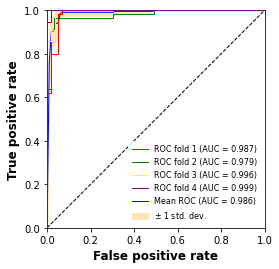

In [14]:
## Plot ROC-Curves Patient Level
tprs = []
aucs = []
i = 1
mean_fpr = np.linspace(0, 1, 100)
colors = ['red', 'green', 'yellow', 'purple']

for dataframe in probabilities_patient:
    fpr, tpr, thresholds = roc_curve(dataframe['Category'], dataframe['Predictions_mean'], pos_label='KolonMet')
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (AUC = %0.3f)' % (i, roc_auc), color = colors[i-1], zorder=3)
    i = i + 1

plt.plot([0,1],[0,1],linestyle = '--',lw = 1,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.3f)' % (mean_auc),
        lw=1, zorder=2)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(aucs, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(aucs, p))
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='moccasin',
                 label='$\pm$ 1 std. dev.', zorder=1)

plt.xlabel('False positive rate', fontsize=12, fontweight='bold')
plt.ylabel('True positive rate', fontsize=12, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xlim(0,1)
plt.ylim(0,1)
plt.gca().set_aspect('equal', adjustable='box')
leg = plt.legend(loc='lower right', fontsize=8)
leg.get_frame().set_linewidth(0.0)
plt.gca().spines['left'].set_zorder(2)
plt.gca().spines['top'].set_zorder(2)
plt.show()

In [242]:
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample
Observer_TablesDir = SSDDir+'/Observer_Tables'
ObserverTables_list = []
n_iterations = 100

## Load in Tables
for a, table in enumerate(os.listdir(Observer_TablesDir)):
    ObserverTable = pd.read_csv(os.path.join(Observer_TablesDir,table))
    ObserverTables_list.append(ObserverTable)

## Bootstrapping
stats = []
accuracy_list = []
sensitivity_list = []
specificity_list = []
ppv_list = []
npv_list = []
tprs_total = []
fprs_total = []
tprs_total_assisted = []
fprs_total_assisted = []

## Calculate original metrics
accuracy_original = []
accuracy_assisted_original = []
tprs_original = []
fprs_original = [] 
tprs_assisted_original = []
fprs_assisted_original = [] 
for table in ObserverTables_list:
    KolonMet_No = table.loc[table['Correct Diagnosis'] == 'KolonMet'].shape[0]
    ICCA_No = table.loc[table['Correct Diagnosis'] == 'ICCA'].shape[0]
    KolonMet_correct = table.loc[(table['Correct Diagnosis'] == 'KolonMet') & (table['Pathologist Diagnosis'] == 'KolonMet')].shape[0]
    KolonMet_correct_assisted = table.loc[(table['Correct Diagnosis'] == 'KolonMet') & (table['Change diagnosis? (y/n)'] == 'KolonMet')].shape[0]
    KolonMet_allPositive = table.loc[table['Pathologist Diagnosis'] == 'KolonMet'].shape[0]
    KolonMet_allPositive_assisted = table.loc[table['Change diagnosis? (y/n)'] == 'KolonMet'].shape[0]
    KolonMet_allNegative = table.loc[table['Pathologist Diagnosis'] == 'ICCA'].shape[0]
    KolonMet_allNegative_assisted = table.loc[table['Change diagnosis? (y/n)'] == 'ICCA'].shape[0]
    KolonMet_correctneg = table.loc[(table['Correct Diagnosis'] == 'ICCA') & (table['Pathologist Diagnosis'] == 'ICCA')].shape[0]
    KolonMet_correctneg_assisted = table.loc[(table['Correct Diagnosis'] == 'ICCA') & (table['Change diagnosis? (y/n)'] == 'ICCA')].shape[0]

    ICCA_correct = table.loc[(table['Correct Diagnosis'] == 'ICCA') & (table['Pathologist Diagnosis'] == 'ICCA')].shape[0]
    ICCA_correct_assisted = table.loc[(table['Correct Diagnosis'] == 'ICCA') & (table['Change diagnosis? (y/n)'] == 'ICCA')].shape[0]

    accuracy_original.append(np.round((KolonMet_correct+ICCA_correct)/(50)*100,2))
    accuracy_assisted_original.append(np.round((KolonMet_correct_assisted+ICCA_correct_assisted)/(50)*100,2))
    
    fpr = table[(table['Correct Diagnosis'] == 'ICCA') & (table['Pathologist Diagnosis']=='KolonMet')].shape[0] 
    tpr = table[(table['Correct Diagnosis'] == 'KolonMet') & (table['Pathologist Diagnosis']=='KolonMet')].shape[0]
    fprs_original.append(fpr/ICCA_No)
    tprs_original.append(tpr/KolonMet_No)
    fpr_assisted = table[(table['Correct Diagnosis'] == 'ICCA') & (table['Change diagnosis? (y/n)']=='KolonMet')].shape[0]
    tpr_assisted = table[(table['Correct Diagnosis'] == 'KolonMet') & (table['Change diagnosis? (y/n)']=='KolonMet')].shape[0]
    fprs_assisted_original.append(fpr_assisted/ICCA_No)
    tprs_assisted_original.append(tpr_assisted/KolonMet_No)

for table in ObserverTables_list:
    tprs = []
    fprs = [] 
    tprs_assisted = []
    fprs_assisted = [] 
    for i in range(n_iterations):
        boot_subset = resample(table)
        boot_subset.reset_index(drop=True, inplace=True)
        boot_subset
        fpr = boot_subset[(boot_subset['Correct Diagnosis'] == 'ICCA') & (boot_subset['Pathologist Diagnosis']=='KolonMet')].shape[0] 
        tpr = boot_subset[(boot_subset['Correct Diagnosis'] == 'KolonMet') & (boot_subset['Pathologist Diagnosis']=='KolonMet')].shape[0]
        KolonTrue = boot_subset[(boot_subset['Correct Diagnosis'] == 'KolonMet')].shape[0]
        ICCATrue = boot_subset[(boot_subset['Correct Diagnosis'] == 'ICCA')].shape[0]
        fprs.append(fpr/ICCATrue)
        tprs.append(tpr/KolonTrue)
        fpr_assisted = boot_subset[(boot_subset['Correct Diagnosis'] == 'ICCA') & (boot_subset['Change diagnosis? (y/n)']=='KolonMet')].shape[0]
        tpr_assisted = boot_subset[(boot_subset['Correct Diagnosis'] == 'KolonMet') & (boot_subset['Change diagnosis? (y/n)']=='KolonMet')].shape[0]
        fprs_assisted.append(fpr_assisted/ICCATrue)
        tprs_assisted.append(tpr_assisted/KolonTrue)
    tprs_total.append(tprs)
    fprs_total.append(fprs)
    tprs_total_assisted.append(tprs_assisted)
    fprs_total_assisted.append(fprs_assisted)

# Calculate TPR and FPR 95% Intervals
fprs_rates = []
tprs_rates = []
fprs_rates_assisted = []
tprs_rates_assisted = []


for observer in tprs_total:
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100
    tpr_lower = np.round(np.percentile(observer, p, axis=0),3)
    p = (alpha+((1.0-alpha)/2.0)) * 100
    tpr_upper = np.round(np.percentile(observer, p, axis=0),3)
    rates = [tpr_lower, tpr_upper]
    tprs_rates.append(rates)

for observer in fprs_total:
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100
    fpr_lower = np.round(np.percentile(observer, p, axis=0),3)
    p = (alpha+((1.0-alpha)/2.0)) * 100
    fpr_upper = np.round(np.percentile(observer, p, axis=0),3)
    rates = [fpr_lower, fpr_upper]
    fprs_rates.append(rates)
    
for observer in tprs_total_assisted:
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100
    tpr_lower = np.round(np.percentile(observer, p, axis=0),3)
    p = (alpha+((1.0-alpha)/2.0)) * 100
    tpr_upper = np.round(np.percentile(observer, p, axis=0),3)
    rates = [tpr_lower, tpr_upper]
    tprs_rates_assisted.append(rates)

for observer in fprs_total:
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100
    fpr_lower = np.round(np.percentile(observer, p, axis=0),3)
    p = (alpha+((1.0-alpha)/2.0)) * 100
    fpr_upper = np.round(np.percentile(observer, p, axis=0),3)
    rates = [fpr_lower, fpr_upper]
    fprs_rates_assisted.append(rates)

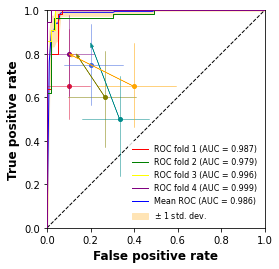

In [287]:
## Plot ROC-Curves Patient Level
tprs = []
aucs = []
i = 1
mean_fpr = np.linspace(0, 1, 100)
colors = ['red', 'green', 'yellow', 'purple']

for dataframe in probabilities_patient:
    fpr, tpr, thresholds = roc_curve(dataframe['Category'], dataframe['Predictions_mean'], pos_label='KolonMet')
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (AUC = %0.3f)' % (i, roc_auc), color = colors[i-1], zorder=3)
    i = i + 1

plt.plot([0,1],[0,1],linestyle = '--',lw = 1,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.3f)' % (mean_auc),
        lw=1, zorder=2)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(aucs, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(aucs, p))
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='moccasin',
                 label='$\pm$ 1 std. dev.', zorder=1)

plt.xlabel('False positive rate', fontsize=12, fontweight='bold')
plt.ylabel('True positive rate', fontsize=12, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xlim(0,1)
plt.ylim(0,1)
plt.gca().set_aspect('equal', adjustable='box')
leg = plt.legend(loc='lower right', fontsize=8)
leg.get_frame().set_linewidth(0.0)
plt.gca().spines['left'].set_zorder(2)
plt.gca().spines['top'].set_zorder(2)
colors = ['crimson', 'olive', 'darkcyan', 'purple', 'orange', 'royalblue']
#colors = ['cornflowerblue', 'cornflowerblue', 'cornflowerblue', 'cornflowerblue', 'cornflowerblue', 'cornflowerblue']

for a in range(6):
    plt.arrow(fprs_original[a],tprs_original[a],(fprs_assisted_original[a]-fprs_original[a]), (tprs_assisted_original[a]-tprs_original[a]),head_width=0.015, head_length=0.02, length_includes_head=True, linewidth=0.5,color=colors[a], zorder=5)
    plt.plot(fprs_original[a],tprs_original[a],linestyle='None', marker='.', markersize=8,color=colors[a])
    plt.plot([fprs_rates[a][0], fprs_rates[a][1]],[tprs_original[a], tprs_original[a]], linestyle='-', linewidth=0.5, marker=None, color = colors[a])
    plt.plot([fprs_original[a], fprs_original[a]],[tprs_rates[a][0], tprs_rates[a][1]], linestyle='-', linewidth=0.5, marker=None, color = colors[a])

plt.savefig(FiguresDir+'TestIt', dpi=1200, bbox_inches='tight')
plt.show()

In [413]:
import random
## Pool results into one single distribution:
## Make a list of correct samples
list_original = []
list_assisted = []
c = 0

for i in range(50):
    corrects = 0
    for a in ObserverTables_list:
        if a.iloc[i]['Correct Diagnosis'] == a.iloc[i]['Pathologist Diagnosis']:
            corrects = corrects + 1
    if (corrects ==3) & (c<3):
            list_original.append('correct')
            c = c + 1
    elif corrects > 3:
            list_original.append('correct')
    else:
        list_original.append('false') 
        
c = 0
for i in range(50):
    corrects = 0
    for a in ObserverTables_list:
        if a.iloc[i]['Correct Diagnosis'] == a.iloc[i]['Change diagnosis? (y/n)']:
            corrects = corrects + 1
    if (corrects ==3) & (c<2):
            list_assisted.append('correct')
            c = c + 1
    elif corrects > 3:
            list_assisted.append('correct')
    else:
            list_assisted.append('false')  

In [476]:
list_original_b = []
list_assisted_b = []
list_original_b_ov = []
list_assisted_b_ov = []

for table in ObserverTables_list:
    list_original_b = []
    for i in range(50):
        if table.iloc[i]['Correct Diagnosis'] == table.iloc[i]['Pathologist Diagnosis']:
            list_original_b.append('correct')
        else:
            list_original_b.append('false')
    list_original_b_ov.append(list_original_b)
            
list_original_b_assisted = []
list_assisted_b_assisted = []
for table in ObserverTables_list:
    list_original_b_assisted = []
    for i in range(50):
        if table.iloc[i]['Correct Diagnosis'] == table.iloc[i]['Change diagnosis? (y/n)']:
            list_original_b_assisted.append('correct')
        else:
            list_original_b_assisted.append('false')
    list_assisted_b_ov.append(list_original_b_assisted)

In [494]:
# Difference in accuracy
accuracy_original = np.round(list_original.count('correct')/(50)*100,2)
accuracy_assisted_original = np.round(list_assisted.count('correct')/(50)*100,2)
diff_original = np.abs(accuracy_assisted_original-accuracy_original)
print(diff_original)

10.0


In [480]:
## Function for pairwise resampling
def pairwise_resampling(list1, list2):
    list = []
    list_b = []
    for i in range(len(list1)):
        if random.random()>=0.5:
            list.append(list1[i])
            list_b.append(list2[i])
        else:
            list.append(list2[i])
            list_b.append(list1[i])
    return list, list_b

def pairwise_resampling_random(list1, list2):
    list = []
    list_b = []
    arr_1 = np.array(list1)
    if bool(arr_1.ndim > 1): ## Check if first list is nested
        for i in range(len(list1[0])):
            if random.random()>=0.5:
                list.append(list1[random.randint(0,5)][i])
                list_b.append(list2[random.randint(0,5)][i])
            else:
                list.append(list2[random.randint(0,5)][i])
                list_b.append(list1[random.randint(0,5)][i])
        return list, list_b
    else:
        for i in range(len(list1)):
            if random.random()>=0.5:
                list.append(list1[i])
                list_b.append(list2[random.randint(0,5)][i])
            else:
                list.append(list2[random.randint(0,5)][i])
                list_b.append(list1[i])
        return list, list_b

In [497]:
## Pool lists (unpaired)
n_iterations = 10
accuracies_pooled  = []
pooled_list = list_original + list_assisted
for i in range(n_iterations):
    resample_pooled_list = resample(pooled_list, replace = False)
    resample_A = resample_pooled_list[0:49]
    resample_B = resample_pooled_list[50:99]
    accuracy_A = np.round(resample_A.count('correct')/(50)*100,2)
    accuracy_B = np.round(resample_B.count('correct')/(50)*100,2)
    accuracy_it = np.abs(accuracy_A-accuracy_B)
    print(accuracy_it)
    accuracies_pooled.append(accuracy_it)

##
p_val = len(np.where(accuracy_it>=diff_original))/n_iterations
print (len(np.where(accuracy_it>=diff_original)))
print(p_val)
print(accuracies_pooled)

6.0
12.0
2.0
6.0
2.0
4.0
4.0
2.0
8.0
10.0
1
0.1
[6.0, 12.0, 2.0, 6.0, 2.0, 4.0, 4.0, 2.0, 8.0, 10.0]


In [436]:
## Pool lists (paired)
n_iterations = 130
count = 0
accuracies_pooled  = []
for i in range(n_iterations):
    resample_A, resample_B = pairwise_resampling(list_assisted, list_original)
    accuracy_A = np.round(resample_A.count('correct')/(50)*100,2)
    accuracy_B = np.round(resample_B.count('correct')/(50)*100,2)
    accuracy_it = np.abs(accuracy_A-accuracy_B)
    accuracies_pooled.append(accuracy_it)

p_val = len(np.where(accuracy_it>=diff_original))/n_iterations
print(p_val)

0.007692307692307693


In [464]:
len(list_assisted_b_ov[0])

300

In [591]:
## Accuracy test list
test_list = []
for i in range(10):
    test_list.append('correct')
test_list.append('false')
for i in range(39):
    test_list.append('correct')

diff_original = np.abs(np.round(test_list.count('correct')/(50)*100,2)-np.round(median_accuracy,2))

In [588]:
diff_original = np.abs(np.round(median_accuracy2,2)-np.round(median_accuracy,2))

In [589]:
diff_original

10.0

In [594]:
## Pool lists (paired)
n_iterations = 100000
count = 0
accuracies_pooled  = []
for i in range(n_iterations):
    resample_A, resample_B = pairwise_resampling_random(test_list, list_original_b_ov)
    accuracy_A = np.round(resample_A.count('correct')/(50)*100,2)
    accuracy_B = np.round(resample_B.count('correct')/(50)*100,2)
    accuracy_it = np.abs(accuracy_A-accuracy_B)
    if accuracy_it >= diff_original:
        count = count + 1
p_val = count/n_iterations
print(p_val)

0.00052


In [558]:
## Permutation test on accuracy
from random import randrange

## Calculate original test metric
## Accuracy
## Calculate original metrics
accuracy_original = []
accuracy_assisted_original = []
tprs_assisted_original = []
fprs_assisted_original = [] 
for table in ObserverTables_list:
    KolonMet_No = table.loc[table['Correct Diagnosis'] == 'KolonMet'].shape[0]
    ICCA_No = table.loc[table['Correct Diagnosis'] == 'ICCA'].shape[0]
    KolonMet_correct = table.loc[(table['Correct Diagnosis'] == 'KolonMet') & (table['Pathologist Diagnosis'] == 'KolonMet')].shape[0]
    KolonMet_correct_assisted = table.loc[(table['Correct Diagnosis'] == 'KolonMet') & (table['Change diagnosis? (y/n)'] == 'KolonMet')].shape[0]
    KolonMet_allPositive = table.loc[table['Pathologist Diagnosis'] == 'KolonMet'].shape[0]
    KolonMet_allPositive_assisted = table.loc[table['Change diagnosis? (y/n)'] == 'KolonMet'].shape[0]
    KolonMet_allNegative = table.loc[table['Pathologist Diagnosis'] == 'ICCA'].shape[0]
    KolonMet_allNegative_assisted = table.loc[table['Change diagnosis? (y/n)'] == 'ICCA'].shape[0]
    KolonMet_correctneg = table.loc[(table['Correct Diagnosis'] == 'ICCA') & (table['Pathologist Diagnosis'] == 'ICCA')].shape[0]
    KolonMet_correctneg_assisted = table.loc[(table['Correct Diagnosis'] == 'ICCA') & (table['Change diagnosis? (y/n)'] == 'ICCA')].shape[0]

    ICCA_correct = table.loc[(table['Correct Diagnosis'] == 'ICCA') & (table['Pathologist Diagnosis'] == 'ICCA')].shape[0]
    ICCA_correct_assisted = table.loc[(table['Correct Diagnosis'] == 'ICCA') & (table['Change diagnosis? (y/n)'] == 'ICCA')].shape[0]

    accuracy_original.append(np.round((KolonMet_correct+ICCA_correct)/(50)*100,2))
    accuracy_assisted_original.append(np.round((KolonMet_correct_assisted+ICCA_correct_assisted)/(50)*100,2))    
    diff_original = np.abs(accuracy_assisted-accuracy_original)

NameError: name 'accuracy_assisted' is not defined